# Improving AI for Brain Lesion Segmentation with FiftyOne

## Motivation

Medical imaging is a huge application space for computer vision and AI. The U.S. medical industry is over 17% of national GDP. With the average age of cancer screenings moving up, it's important to facilitate the rapid development of medical CV by allowing practitioners to robustly curate datasets, annotations, and develop models directly on top of the data platform. FiftyOne is well-positioned to become an irreplacable tool in the model development pipeline. However, medical imaging also offers a unique set of challenges such as unique file types, 3D volumetric data, and unique image metadata per application. Additionally, medical imaging tasks are frequently comprised of "non-natural" images, which may not facilitate acceptable performance from pretrained foundational imaging models.<br>

In this notebook, I demo'd using FiftyOne as a core tool in developing a brain tumor segmentation model from mri. I worked around incompatibilites encountered with the .tif database, visualize the dataset in FiftyOne to inform the development of the subsequent Torch dataloader, and visually confirmed improving segmentation performance of my model in FiftyOne.<br>

## Methods
Models: 2D UNet implemented in PyTorch<br>
Model Weights: available on <a href="https://drive.google.com/drive/folders/1ECU41KCEGHFGLWS6wfiJH6dKN03fDmwV?usp=sharing">This Google Drive</a><br>
Dataset: FLAIR Brain MRI - Segmenting Low-Grade Glioma Tumors<br>
Core Tools: FiftyOne, Pytorch, Numpy<br>

## To do:
<ul>
    <li>Find or write a FiftyOne extension to improve viewing of 3D volumes of image slices</li>
    <li>Compare performance to Segment Anything Model - default vith weights were having some issues to look into</li>
    <li>Contribute TotalSegmentator to the FiftyOne model zoo</li>
</ul>


<i>
Prepared by: Bryan Bednarski, September 2023<br>
Github: https://github.com/bbednarski9/FiftyOne_UNet_FLAIR<br>
Email: bryanbed@g.ucla.edu<br>
</i>

### 0.0 Requirements:
see environment.yml at project root <br>

In [1]:
#!pip install fiftyone

### 1.0 Setup:
Import the packages we will need for this demonstration, check our version of FiftyOne

In [2]:
import os
import fiftyone as fo
from fiftyone.core.labels import Detection, Detections
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
import numpy as np
import re, tifffile
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random

# notebook directory
ROOT_DIR = os.getcwd()
print(f"Current directory: {ROOT_DIR}")

# for dev only - will allow live changes to source w/o restarting .ipyng kernel
# %load_ext autoreload
# %autoreload 2

Current directory: /home/bryanbed/Projects/FiftyOne_UNet_FLAIR


In [3]:
# get FiftyOne version
print(f"FiftyOne version: {fo.__version__}")

# # OPTIONAL + RUN ONCE:  Download voxel gpt plugin and set API key - just for fun :)
# #!fiftyone plugins download https://github.com/voxel51/voxelgpt
# #!fiftyone plugins requirements @voxel51/voxelgpt --install
# import openai
# os.environ["OPENAI_API_KEY"] = "XXXXXXXXXXXXXXXXX"
# openai.api_key = os.getenv("OPENAI_API_KEY")
# print(f"Open API Key set to: {openai.api_key}")

FiftyOne version: 0.21.6


### 2.0 Setting up the LGG MRI Segmentation dataset.

If cloning from the github repo takes too long, you can download the LGG-MRI dataset from <a href="https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?resource=downloadhttps://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?resource=download">this Kaggle challenge page</a> <br>
The data should be saved to: <working_directory>/FiftyOne_UNet_FLAIR/data/ with a the same hierarchy to RAW_DATA_PATH below.<br><br>
<i>From data source page: "This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.The images were obtained from The Cancer Imaging Archive (TCIA). They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available."</i>

In [5]:
# setup relative data paths to root
RAW_DATA_PATH      = ROOT_DIR + "/data/lgg-mri-segmentation/kaggle_3m/"
PROCESSED_NPY_PATH = ROOT_DIR + "/data/lgg-mri_numpy/"
TEMP_PNG_PATH      = ROOT_DIR + "/data/lgg-mri_orig_png/"
DIR_CHECKPOINT     = ROOT_DIR + "/model_weights/unet_checkpoints/"
SEED = 42

from source.torch_config import torch_and_cuda_setup
torch_and_cuda_setup(SEED)

Torch version: 2.0.1
CUDA version: 11.7
CUDA available: True
GPU ID: NVIDIA GeForce GTX 1080


In [6]:
'''
data split: 90% training, 10% testing
'''
patients = [d for d in os.listdir(RAW_DATA_PATH) if os.path.isdir(os.path.join(RAW_DATA_PATH, d)) and d.startswith('TCGA')]
train_patients, test_patients = train_test_split(patients, test_size=0.1, random_state=SEED)
print(f"Number of image series: {len(patients)}, (train: {len(train_patients)}, test: {len(test_patients)})")

Number of image series: 110, (train: 99, test: 11)


### 2.0 View the raw data and masks as a FiftyOne dataset

First, define a few helper methods to make help with some file conversions.<br>
All of these tools also live in source.data_tools.py for reference.

In [7]:
def parse_img_mask_filenames(all_files, extension):
    """
    Sort the files in the patient subdirectory into image and mask lists.
    """
    imgs, masks = [], []
    mask_extension = '_mask'+extension
    for file in all_files:
        if file.endswith(extension):
            if file.endswith(mask_extension):
                masks.append(file)
            else:
                imgs.append(file)
    return imgs, masks

def sort_filenames_in_series(files, patient_id, extension):
    files_clean = files.copy()
    files_clean = [file.strip(extension) for file in files_clean]
    files_clean = [file.strip('_mask') for file in files_clean]
    files_clean = [file.replace(patient_id+"_", "") for file in files_clean]
    sort_order = np.argsort(files_clean)
    files = [files[i] for i in sort_order]
    return files

def convert_tif_to_npy(old_patient_dir, new_patient_dir, img, return_sample=False):
    fp_tif = os.path.join(old_patient_dir, img)
    # load the .tif file as a numpy array
    img_arr = tifffile.imread(fp_tif)
    # define and use a regular expression to extract the slide name from the filepath
    np.save(os.path.join(new_patient_dir, img.replace('.tif', '.npy')), img_arr)
    if return_sample:
        return img_arr # THIS IS A NUMPY ARRAY
    else:
        return None
    
def convert_npz_to_jpeg(old_patient_dir, new_patient_dir, img, return_sample=False):
    fp_np = os.path.join(old_patient_dir, img)
    # load the .tif file as a numpy array
    img_arr = np.load(fp_np)
    # define and use a regular expression to extract the slide name from the filepath
    img_pil = Image.fromarray(img_arr)
    img_pil.save(os.path.join(new_patient_dir, img.replace('.npy', '.jpeg')), "JPEG")
    if return_sample:
        return img_pil # THIS IS A PIL IMAGE
    else:
        return None

'''
.tif direcotry to .npy directory
'''
def tif_dirs_to_npz(root_tif_dir, root_npz_dir, patients, return_sample=False):
    """
    Convert all .tif files in the root_npz_dir to .jnpz files and save them in the root_npz_dir.
    """
    # if root_npz_dir exists, delete it and all contents, then create it
    # otherwise, just make it
    if os.path.exists(root_npz_dir):
        shutil.rmtree(root_npz_dir)
    os.makedirs(root_npz_dir)

    # use parse_img_mask_filenames and sort_filenames_in_series to get the correct order of the files
    # then convert the .tif files at those paths into numpy arrays
    for patient in tqdm(patients, unit="patient files converted from .tif to .npy"):
        patient_dir = os.path.join(root_tif_dir, patient)
        all_files = sorted(os.listdir(patient_dir))
        # sort the files into image and mask lists
        imgs, masks = parse_img_mask_filenames(all_files, '.tif')
        # sort the series into the correct order
        imgs = sort_filenames_in_series(imgs, patient, '.tif')
        masks = sort_filenames_in_series(masks, patient, '.tif')

        # if patient directory doesnt exist in PROCESSED_DATA_PATH, create it
        old_patient_dir = os.path.join(root_tif_dir, patient)
        new_patient_dir = os.path.join(root_npz_dir, patient)
        if not os.path.exists(new_patient_dir):
            os.makedirs(new_patient_dir)

        for img in imgs: img_npz_sample = convert_tif_to_npy(old_patient_dir, new_patient_dir, img, return_sample=True)
        for mask in masks: mask_npz_sample = convert_tif_to_npy(old_patient_dir, new_patient_dir, mask, return_sample=True)

    if return_sample:
        return img_npz_sample, mask_npz_sample
    else:
        return None, None


'''
.npy direcotry to .jpeg directory
'''
def npz_dirs_to_jpeg(root_npz_dir, root_jpg_dir, patients, return_sample=False):
    """
    Convert all .npy files in the root_npz_dir to .jpg files and save them in the root_jpg_dir.
    """
    # if root_jpg_dir exists, delete it and all contents, then create it
    # otherwise, just make it
    if os.path.exists(root_jpg_dir):
        shutil.rmtree(root_jpg_dir)
    os.makedirs(root_jpg_dir)

    for patient in tqdm(patients, unit="patient files converted from .npy to .jpg"):
        patient_dir = os.path.join(root_npz_dir, patient)
        all_files = sorted(os.listdir(patient_dir))
        # sort the files into image and mask lists
        imgs, masks = parse_img_mask_filenames(all_files, '.npy')
        # sort the series into the correct order
        imgs = sort_filenames_in_series(imgs, patient, '.npy')
        masks = sort_filenames_in_series(masks, patient, '.npy')
    
        # if patient directory doesnt exist in PROCESSED_DATA_PATH, create it
        old_patient_dir = os.path.join(root_npz_dir, patient)
        new_patient_dir = os.path.join(root_jpg_dir, patient)
        if not os.path.exists(new_patient_dir):
            os.makedirs(new_patient_dir)

        for img in imgs: img_jpg_sample = convert_npz_to_jpeg(old_patient_dir, new_patient_dir, img, return_sample=True)
        for mask in masks: mask_jpg_sample = convert_npz_to_jpeg(old_patient_dir, new_patient_dir, mask, return_sample=True)

    if return_sample:
        return img_jpg_sample, mask_jpg_sample
    else:
        return None, None

In [8]:
'''
source a few helper functions
'''
from source.data_tools import tif_dirs_to_npz, npz_dirs_to_png

The LGG-MRI dataset is stored as .tif, which is currently not supported for visualization in Fiftyone. Therefore, I'll do a quick lossless conversation of the entire .tif image and mask file dataset over to numpy (for model training) and png (for FiftyOne visualization)

100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  9.00patient files converted from .tif to .npy/s]

image sample shape: (256, 256, 3)
mask_sample_shape: (256, 256)


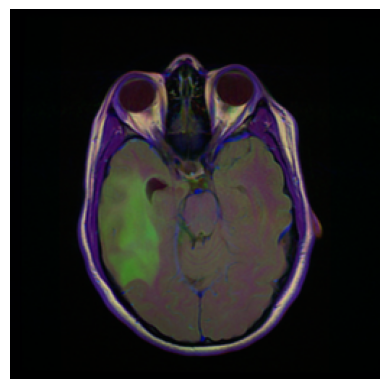

In [9]:
'''
convert all .tif files to .npy and validate a sample visually
'''
img_npz_sample, mask_npz_sample = tif_dirs_to_npz(RAW_DATA_PATH, PROCESSED_NPY_PATH, patients, return_sample=True)
# print out numpy array shape
print(f"image sample shape: {img_npz_sample.shape}")
print(f"mask_sample_shape: {mask_npz_sample.shape}")
plt.imshow(img_npz_sample)
plt.axis('off')  # To turn off axis numbers and ticks
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [01:23<00:00,  1.32patient files converted from .npy to .jpg/s]

image sample shape: (256, 256)
mask_sample_shape: (256, 256)


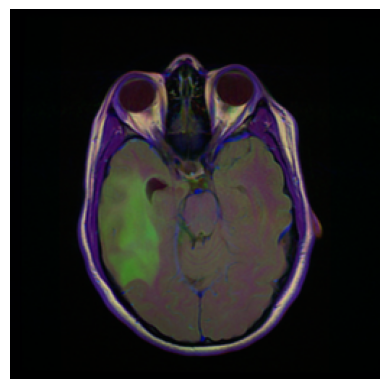

In [10]:
'''
convert all .npy files to .png and validate a sample visually
'''
img_png_sample, mask_png_sample = npz_dirs_to_png(PROCESSED_NPY_PATH, TEMP_PNG_PATH, patients, return_sample=True)
#print out png shape and sample image
print(f"image sample shape: {img_png_sample.size}")
print(f"mask_sample_shape: {mask_png_sample.size}")
plt.imshow(img_png_sample)
plt.axis('off')  # To turn off axis numbers and ticks
plt.show()

In [11]:
from source.data_tools import parse_img_mask_filenames, sort_filenames_in_series

def get_bbox_coords(mask_arr):
    """
    Given a mask array, return the bounding box coordinates as [<top-left-x>, <top-left-y>, <width>, <height>]
    """
    (shape_x,shape_y) = mask_arr.shape
    # get the indices of the non-zero elements in the mask array
    mask_indices = np.nonzero(mask_arr)
    # get the min and max x and y coordinates
    min_x, max_x = mask_indices[0].min(), mask_indices[0].max()
    min_y, max_y = mask_indices[1].min(), mask_indices[1].max()
    # calculate width and height
    width = max_x - min_x
    height = max_y - min_y
    # return the bounding box coordinates
    return [min_y/shape_y, min_x/shape_x, height/shape_y, width/shape_x]

'''
.jpeg directory to fiftyone dataset
'''
def image_dirs_to_fiftyone(root_img_dir, patients, add_gt_images, add_gt_masks, pred_mask_dirs, pred_mask_labels, root_npy_dir):
    """
    create a fiftyone dataset and load all .jpg files in the root_jpg_dir into the dataset.
    """
    assert len(pred_mask_dirs) == len(pred_mask_labels),\
                f'predicted_mask_dirs and predicted_mask_labels must \
                be same length, got: {len(predicted_mask_dirs)} and {len(predicted_mask_labels)}'
    dataset = fo.Dataset()
    for patient in tqdm(patients, unit="patient png slices loaded into fiftyone dataset"):
        patient_dir = os.path.join(root_img_dir, patient)
        all_files = sorted(os.listdir(patient_dir))
        # sort the files into image and mask lists
        imgs, masks = parse_img_mask_filenames(all_files, '.png')

        # sort the series into the correct order
        imgs = sort_filenames_in_series(imgs, patient, '.png')
        masks = sort_filenames_in_series(masks, patient, '.png')

        if add_gt_images:
            for mask, img in zip(masks,imgs):
                sample = fo.Sample(filepath=os.path.join(patient_dir, img),
                                            tags=["mri slice", patient])
                if add_gt_masks:
                    mask_path = os.path.join(patient_dir, mask)
                    label = fo.core.labels.Segmentation(mask_path=mask_path)
                    sample.add_labels(labels=label, label_field="lesion_mask")
                    # read png from mask_path, if its not all zeros, add a bbox around it
                    # @ todo: extending bounding box estimation to the predicted masks also
                    # mask_arr = np.array(Image.open(mask_path))
                    # if mask_arr.sum() > 0:
                    #     bbox_coords = get_bbox_coords(mask_arr)
                    #     detections = Detections(detections=[Detection(label="lesion_bbox",bounding_box=bbox_coords,mask=None,confidence=1.0)])
                    #     sample.add_labels(labels=detections, label_field="lesion_bbox")
                        
                if len(pred_mask_dirs) > 0:
                    for mask_dir, mask_label in zip(pred_mask_dirs, pred_mask_labels):
                        mask_patient_dir = os.path.join(mask_dir, patient)
                        mask_path = os.path.join(mask_patient_dir, mask)
                        label = fo.core.labels.Segmentation(mask_path=mask_path)
                        sample.add_labels(labels=label, label_field=mask_label)
                
                dataset.add_sample(sample)
    return dataset

In [12]:
'''
load a .jpeg directory into a fiftyone dataset and view all samples simultaneously
'''
dataset = image_dirs_to_fiftyone(TEMP_PNG_PATH, test_patients, add_gt_images=True, add_gt_masks=True, pred_mask_dirs=[], pred_mask_labels=[], root_npy_dir=PROCESSED_NPY_PATH)

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.67patient png slices loaded into fiftyone dataset/s]


In [13]:
'''
UNCOMMENT TO LAUNCH FIFTYONE
'''
#session = fo.launch_app(dataset)

'\nUNCOMMENT TO LAUNCH FIFTYONE\n'

In [14]:
'''
UNCOMMENT TO CLOSE FIFTYONE
'''
#session.close()

'\nUNCOMMENT TO CLOSE FIFTYONE\n'

LGG-MRI tumor segmentation and bounding boxes in FiftyOne

![Image](./demo_images/tumor_segment_example1.jpg)

### 3.0 Create a custom 2D Unet tumor segmentation model

#### 3.1 Define the dataloader

In [15]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
"""
Create a pytorch dataset class for the FlairDataset, which has image and mask series
stored within subdirectories of the data_root. Each patient ID-named subdirectory contains a series of
images and masks for a single patient. The images and masks are stored as .png files.
"""
class FlairTorchDataset(Dataset):
    def __init__(self, data_root, patients, transform=None):
        """
        Args:
            data_root (string): root directory with patient subdirectories
            patients (list): list of patient subdirectories
            transform (callable, optional): optional transform to be applied
        """
        self.data_root = data_root
        self.transform = transform
        assert len(patients) > 0, "Patient list is empty - not allowed"
        self.patients = patients
        self._init_patient_slice_pairs(include_images=True, include_masks=True, validate_idx=True)


    def _init_patient_slice_pairs(self, include_images: bool, include_masks: bool, validate_idx: bool):
        """
        create lists of all image and mask paths in the same order
        """
        self.all_imgs, self.all_masks = [], []
        for patient in tqdm(self.patients, unit="patient png slices and masks parsed"):
            patient_dir = os.path.join(self.data_root, patient)
            all_files = sorted(os.listdir(patient_dir))
            # sort the files into image and mask lists
            imgs, masks = parse_img_mask_filenames(all_files, '.npy')

            # sort the series into the correct order
            imgs = sort_filenames_in_series(imgs, patient, '.npy')
            masks = sort_filenames_in_series(masks, patient, '.npy')
            assert len(imgs) == len(masks), "length of image list (imgs) \
                                            and mask list (masks) must be equivalent"
            # sanity check to make sure that all patient IDs and slice IDs still match
            if validate_idx:
                for i,_ in enumerate(imgs):
                    img_pth  = imgs[i].replace(".npy","")
                    mask_pth = masks[i].replace("_mask.npy","")
                    assert img_pth == mask_pth, f"image ID ({img_pth}) and mask ID ({mask_pth}) paths must be the same" 
            
            imgs = [os.path.join(self.data_root, patient, img) for img in imgs]
            masks = [os.path.join(self.data_root, patient, mask) for mask in masks]
            
            if include_images: self.all_imgs  = self.all_imgs + imgs
            if include_masks:  self.all_masks = self.all_masks + masks
        assert len(self.all_imgs) == len(self.all_masks), "length of image list (imgs) \
                                                            and mask list (masks) must be equivalent"

    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        """
        Args:

        Returns:
            sample (dict): dictionary containing the image and mask tensors. Tensors
            are 2D of shape (C x H x W) for images slices and (H x W) for mask slices respectively.
        """

        img  = torch.from_numpy(np.load(self.all_imgs[idx])).permute(2,0,1)
        mask = torch.from_numpy(np.load(self.all_masks[idx]))
        sample = {'image': img,
                  'mask': torch.clamp(mask, min=0, max=1),
                  'image_pth':self.all_imgs[idx],
                  'mask_pth':self.all_masks[idx]
                 }
        if self.transform:
            sample = self.transform(sample)
        return sample

#### 3.2 Create our dataloaders

In [16]:
from source.unet_2d.unet_model import UNet
from source.unet_2d.train import train_unet
from source.unet_2d.predict import apply_unet

train_config = {
    'epochs': 25,
    'batch_size': 16,
    'lr': 1e-5,
    'load': False,
    'scale': 0.5,
    'amp': False,
    'bilinear': False,
    'classes': 1,
    'dir_checkpoint': DIR_CHECKPOINT,
}

# Create torch datasets for the training and validation/testing populations
#torch_dataset_allpats = FlairTorchDataset(data_root=PROCESSED_NPY_PATH, patients=patients, transform=None)
#print(f"All slice count: {len(torch_dataset_allpats)}")
torch_dataset_train = FlairTorchDataset(data_root=PROCESSED_NPY_PATH, patients=train_patients, transform=None)
print(f"Train slice count: {len(torch_dataset_train)}")
torch_dataset_test = FlairTorchDataset(data_root=PROCESSED_NPY_PATH, patients=test_patients, transform=None)
print(f"Test slice count: {len(torch_dataset_test)}")

# Create torch dataloaders
train_dataloader = DataLoader(torch_dataset_train, batch_size=train_config['batch_size'], shuffle=True, generator=torch.Generator(device='cuda'))
test_dataloader  = DataLoader(torch_dataset_test, batch_size=1, shuffle=True, generator=torch.Generator(device='cuda'))

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 4770.80patient png slices and masks parsed/s]


Train slice count: 3591


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1741.10patient png slices and masks parsed/s]

Test slice count: 338


#### 3.3 Define and train the UNet model

In [ ]:
model = UNet(n_channels=3, n_classes=train_config['classes'], bilinear=train_config['bilinear'])

train_unet(model,
           train_config['epochs'],
           train_config['batch_size'],
           train_config['lr'],
           train_config['load'],
           train_config['scale'],
           train_config['amp'],
           train_dataloader,
           test_dataloader,
           train_config['dir_checkpoint']
          )

INFO: Using device cuda
INFO: Network:
	3 input channels
	1 output channels (classes)
	Transposed conv upscaling
ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


cuda


wandb: Currently logged in as: anony-mouse-622453317190631222. Use `wandb login --relogin` to force relogin


INFO: Starting training:
        Epochs:          25
        Batch size:      16
        Learning rate:   1e-05
        Training size:   225
        Validation size: 338
        Checkpoints:     True
        Device:          cuda
        Images scaling:  0.5
        Mixed Precision: False
    
Validation round:  99%|███████████████████▊| 335/338 [00:07<00:00, 45.30batch/s]
                                                                                INFO: Validation Dice score: 0.015922699123620987
Validation round:  99%|███████████████████▊| 335/338 [00:07<00:00, 44.17batch/s]
                                                                                INFO: Validation Dice score: 0.01608658954501152
Validation round:  99%|███████████████████▊| 335/338 [00:07<00:00, 43.23batch/s]
                                                                                INFO: Validation Dice score: 0.013086496852338314
Validation round:  99%|███████████████████▊| 335/338 [00:07<00:00, 44.27b

#### 3.4 Evaluate the UNet's performance at 1 epoch

In [18]:
'''
Evaluate the performance of our UNET model saved after 1 epoch of training in terms of DICE score
'''
EVAL_EPOCH = 1
UNET_SEGS_PATH1 = ROOT_DIR + f"/data/lgg-mri_unet_segs_e{EVAL_EPOCH}/"
model = UNet(n_channels=3, n_classes=train_config['classes'], bilinear=train_config['bilinear'])
state_dict = torch.load(os.path.join(DIR_CHECKPOINT, f'checkpoint_epoch{EVAL_EPOCH}.pth'))
model.load_state_dict(state_dict)
test_dice = apply_unet(model, test_dataloader, UNET_SEGS_PATH1)
print(f"model test dice score: {test_dice}")

model test dice score: 0.616202712059021


In [19]:
'''
Load saved masks from Epoch=1 Unet validation into the FiftyOne dataset 
'''
# convert all .npy predictions files to .png
img_png_sample, mask_png_sample = npz_dirs_to_png(UNET_SEGS_PATH1, UNET_SEGS_PATH1, test_patients, return_sample=True)
#print out png shape and sample image
#print(f"image sample shape: {img_png_sample.size}")
print(f"mask_sample_shape: {mask_png_sample.size}")

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.89patient files converted from .npy to .jpg/s]

mask_sample_shape: (256, 256)


In [20]:
'''
load our test cohort slices, ground truth masks, and UNet (1epoch) masks into FiftyOne Dataset
'''
dataset = image_dirs_to_fiftyone(TEMP_PNG_PATH,
                                 test_patients,
                                 add_gt_images=True,
                                 add_gt_masks=True,
                                 pred_mask_dirs=[UNET_SEGS_PATH1],
                                 pred_mask_labels=["UNet_mask_epoch1"],
                                 root_npy_dir=PROCESSED_NPY_PATH
                                )

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.81patient png slices loaded into fiftyone dataset/s]


In [21]:
'''
UNCOMMENT TO LAUNCH FIFTYONE
'''
#session = fo.launch_app(dataset)

'\nUNCOMMENT TO LAUNCH FIFTYONE\n'

In [22]:
'''
UNCOMMENT TO CLOSE FIFTYONE
'''
#session.close()

'\nUNCOMMENT TO CLOSE FIFTYONE\n'

#### UNet 1 epoch training example:
We've now loaded the test split's slices, ground truth segmentations, and UNet segmentations into a Fiftyone dataset. The Dice loss performance indicates moderate to poor performance of the model after just 1 epoch of training, and we can confirm this unimpressive performance visually with FiftyOne. In the first image below, the white segmentation mask  Label: "lesion_mask" is through ground truth, while the dark mask Label: "UNet_mask_epoch1" is the corresponding inference. Visually we see that the 50-60% of correctly labeled mask corresponds well with our overall dice loss of 0.61 for this model.<br>
In the second image below, we view a handful of Samples, which are slices from the same patient, and confirm mostly consistent performance across the board.

![Image](./demo_images/tumor_segment_example2-1.png)

![Image](./demo_images/tumor_segment_example2-2.png)

#### 3.5 Compare the UNet's performance at 25 epochs

In [23]:
'''
Evaluate the performance of our UNET model saved after 25 epochs of training in terms of DICE score
'''
EVAL_EPOCH = 25
UNET_SEGS_PATH25 = ROOT_DIR + f"/data/lgg-mri_unet_segs_e{EVAL_EPOCH}/"
model = UNet(n_channels=3, n_classes=train_config['classes'], bilinear=train_config['bilinear'])
state_dict = torch.load(os.path.join(DIR_CHECKPOINT, f'checkpoint_epoch{EVAL_EPOCH}.pth'))
model.load_state_dict(state_dict)
test_dice = apply_unet(model, test_dataloader, UNET_SEGS_PATH25)
print(f"model test dice score: {test_dice}")

model test dice score: 0.8150453567504883


In [24]:
'''
Load saved masks from Epoch=10 Unet validation into the FiftyOne dataset 
'''
# convert all .npy predictions files to .png
img_png_sample, mask_png_sample = npz_dirs_to_png(UNET_SEGS_PATH25, UNET_SEGS_PATH25, test_patients, return_sample=True)
#print out png shape and sample image
#print(f"image sample shape: {img_png_sample.size}")
print(f"mask_sample_shape: {mask_png_sample.size}")

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.82patient files converted from .npy to .jpg/s]

mask_sample_shape: (256, 256)


In [25]:
dataset = image_dirs_to_fiftyone(TEMP_PNG_PATH,
                                 test_patients,
                                 add_gt_images=True,
                                 add_gt_masks=True,
                                 pred_mask_dirs=[UNET_SEGS_PATH1, UNET_SEGS_PATH25],
                                 pred_mask_labels=["UNet_mask_epoch1","UNet_mask_epoch25"],
                                 root_npy_dir=PROCESSED_NPY_PATH
                                )

100%|█████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.18patient png slices loaded into fiftyone dataset/s]


In [26]:
'''
UNCOMMENT TO LAUNCH FIFTYONE
'''
#session = fo.launch_app(dataset)

'\nUNCOMMENT TO LAUNCH FIFTYONE\n'

In [27]:
'''
UNCOMMENT TO CLOSE FIFTYONE
'''
#session.close()

'\nUNCOMMENT TO CLOSE FIFTYONE\n'

#### UNet 25 epoch training example:
Improved Dice loss after 25 epochs of training (0.815 vs. 0.616), should result in better overall segmentations. Taking a look at the same sample we confirm this and see the massive improvement made in just a few training epochs. However, now the model seems to be over-estimating the tumor segment size. Further training could correct this - or you may need to look into adding soome data augmentations, optimizing model parameters, or tweaking the loss function and optimizer. Either way, hoopefully this notebook got you off to a great start on your way to building the future of AI-driven medical imaging systems while using FiftyOne manage your databases!<br>

Sharing data across your team and need improved version and access control? Check out <a href="https://voxel51.com/fiftyone-teams/">FiftyOne Teams</a>

![Image](./demo_images/tumor_segment_example3-1.png)

![Image](./demo_images/tumor_segment_example3-2.png)

## Thanks for your attention!